## PlotBot Analysis

In [175]:
# Dependencies
import tweepy
import json
import matplotlib.pyplot as plt
import datetime
import re
import time

In [176]:
# Twitter API Keys
consumer_key = "cSyd0FAKhKJHFeBjQZrxT1O7z"
consumer_secret = "TxHReDx6CKIpSbdHoaD4fyBxlweOSz9Gf6hM9vFb8Ko8kThq6z"
access_token = "909773742640959488-mgAbQBtipmxFIBHH7H9N0hLv6yhJAsU"
access_token_secret = "7HYPrdLpjEkbjMeMf3Czp9hBBuMajCT3VhhmBlxkTfPg3"
# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [177]:
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [178]:
#Set search terms for the twitter accounts to be analyzed and the accounts analyzed previously
search_term1="@dyu3141 Analyze: @"
search_term2="New Tweet Analysis: @"

# "Real Person" Filters
min_tweets = 5
max_tweets = 10000
max_followers = 2500
max_following = 2500
lang = "en"

## Define a function to retrieve the accounts analyzed previously


In [179]:
def analyzed_accounts():
    
    target_user="@PlotBot5"
    #Get the most recent tweet id from the account
    most_recent_tweet=api.user_timeline(target_user, count=1, result_type="recent")
    most_recent_id=most_recent_tweet[0]['id_str']
    
    #Get the tweets from the account
    public_tweets=api.user_timeline(target_user, count=40, max_id=most_recent_id)
    
    #Set a list for the accounts analyzed previously
    analyzed_accs=[]
    
    #Loop through all the tweets to find the tweets containing accounts analyzed previously
    for tweet in public_tweets:
        #Search for the "New Tweet Analysis" in the tweets
        if re.search(search_term2, tweet['text']) is not None:
            
            #Extract the accounts analyzed previously
            try:
                analyzed_acc=tweet['text'].split('New Tweet Analysis: ')[1].split(' ')[0]
                analyzed_accs.append(analyzed_acc)
            
            #if errors happen...
            except:
                pass
    
    #Return the list of all accounts that have been analyzed previously        
    return analyzed_accs

#print(analyzed_accounts())

## Define a function to search for requests for twitter analysis


In [180]:
def search_for_request(old_tweet_id):
    
    # Set the target_user recieving all requests
    target_user="@dyu3141"
    
    #Get the recent tweets directed to the account
    public_tweets=api.search(target_user, count=40, result_type='recent', since_id=old_tweet_id)
    
    # Set a dictionary to store the requestors' accounts and the accounts for analysis
    requests=dict()
    
    #Loop through the tweets to get all the accounts requested for analysis
    for tweet in public_tweets['statuses']:    
       
        # Use filters to check if user meets conditions
        if (tweet["user"]["followers_count"] < max_followers and
            tweet["user"]["statuses_count"] > min_tweets and
            tweet["user"]["statuses_count"] < max_tweets and
            tweet["user"]["friends_count"] < max_following and
                tweet["user"]["lang"] == lang):

            #Check if the the request info is contained in the tweet text
            if re.search(search_term1, tweet['text']) is not None:
                    
                #Extract the account requested for analysis
                requestor_account='@' + tweet['user']['screen_name']
                    
                #Extract the accounts requested for analysis and store in the dictionary
                try:
                    acc_requested=tweet['text'].split('@dyu3141 Analyze: ')[1]
                    requests[tweet['id']]=[requestor_account, acc_requested]
                    
                #Skip errors in case
                except:
                    pass
    
    # Create a variable for holding the oldest tweet
    old_tweet=public_tweets['statuses'][0]
    old_tweet_id=old_tweet['id_str']
    
    #Return the dictionary containing requestors' accounts and analysis accounts, and the old tweet id
    return requests, old_tweet_id
                            
#print(search_for_request(counter_limit, old_tweet_id))

## Define a function for sentiment analysis, graph plotting and tweeting out the results


In [181]:
def sentiment_analysis(target_user, requestor_account, counter):
    
    # Variables for holding sentiments
    compound_list = []
    
    # Loop through 25 pages of tweets (total 500 tweets)
    for x in range(25):

        # Get all tweets from home feed
        public_tweets = api.user_timeline(target_user, page=x)

        # Loop through all tweets
        for tweet in public_tweets:

            # Run Vader Analysis on each tweet
            compound = analyzer.polarity_scores(tweet['text'])["compound"]
            
            # Add each value to the appropriate list
            compound_list.append(compound)

    #Check if the compound_list is not zero value
    if sum(compound_list) > 0:        
        # Create a plot  
        plt.figure(figsize=(12,8))

        #Set the x axis 
        x_axis=[i-500 for i in range(len(compound_list))]
    
        #Plot the graph
        plt.plot(x_axis, compound_list, marker='o', 
             linewidth=0.25, alpha=1, label=("Tweets " + target_user))
    
        #Set other graph properties
        plt.xlim(-len(compound_list),0)
        plt.ylim(-1.0, 1.0)
        plt.ylabel("Tweet Polarity")
        plt.xlabel("Tweets Ago")
        plt.title("Sentiment Analysis of Tweets (" + str(datetime.date.today()) + ")")
        plt.legend(bbox_to_anchor=(1,1))
        plt.grid(True)
    
        # Save the figure
        file_path = "analysis" + str(counter + 1) + ".png"
        plt.savefig(file_path)
        plt.show()
        counter += 1
        #Assign the tweet text
        tweet="New Tweet Analysis: " + target_user + "(Thx " + requestor_account + "!!)"
    
        #Tweet the graphs to "@PlotBot5"
        api.update_with_media(file_path, tweet,'@PlotBot5')
    return counter

## Execution of request search and sentiment analysis

--------------------
counter= 0
old_tweet_id= 


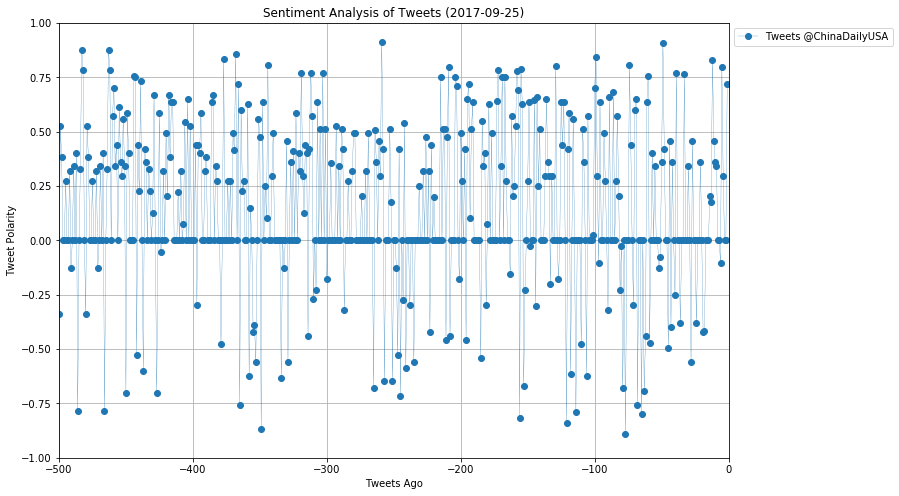

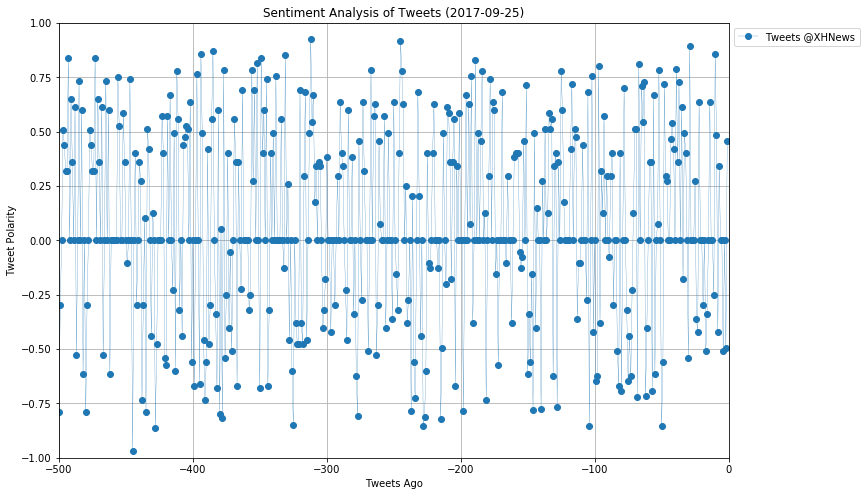

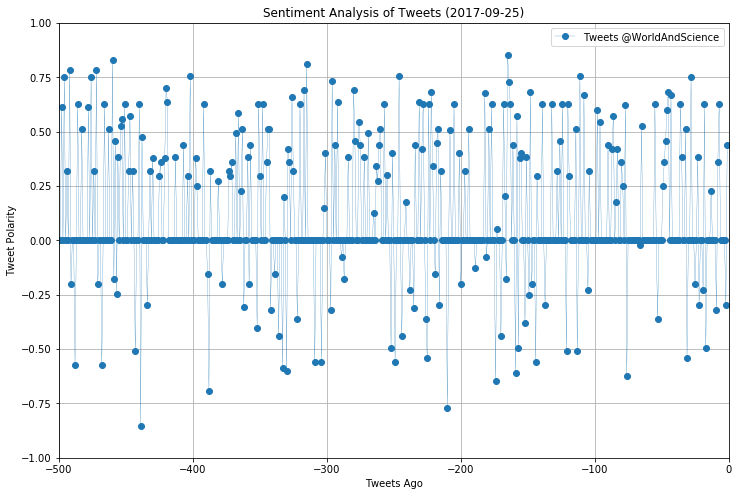

KeyboardInterrupt: 

In [182]:
# Assign the the oldest tweet (i.e. the max_id) etc
old_tweet_id=""
counter=0

#Infinitively loop if the counter has not reached the limit of 3
while(counter < 3):
    
    # Print the counter limit and the oldest tweet id at the beginning of each run
    print('--------------------')
    print(('counter= ') + str(counter))
    print('old_tweet_id= ' + old_tweet_id)
    
    # Search for the requests for account analysis
    try:
        search_results=search_for_request(old_tweet_id)
        
        #Store the request info
        requests=search_results[0]
            
        #Loop through the accounts requested for analysis
        for item in requests.values():
                
            #Extract the requestor's account
            requestor_acc=item[0]
                
            #Extract the account for analysis
            acc=item[1]
                
            #Check if the account has been analyzed previously
            if acc not in analyzed_accounts():
                    
                #Perform sentiment analysis and return the counter of accounts analyzed
                counter=sentiment_analysis(acc, requestor_acc, counter)
                                                           
        #Assign new old_tweet_id
        old_tweet_id=str(int(search_results[1])+1)
    
    #Skip errors
    except:
        pass
    
    #Scan the account recieving requests every five minutes
    time.sleep(300)